### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# 使用 colab 環境的同學請執行以下程式碼
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

import os
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
%cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
1.15.0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive'
/content/gdrive/My Drive/Colab Notebooks


In [18]:
% ls -al
% cd 'Colab Notebooks'

total 396563
-rw------- 1 root root     82984 Dec  9  2018 '20181209_ex7_keras (1).ipynb'
-rw------- 1 root root     72303 Dec 10  2018  20181209_ex7_keras.ipynb
-rw------- 1 root root  17152072 Feb  4 06:43  best_weights.h5
-rw------- 1 root root  17275224 Feb  4 03:11  best_weights_hw.h5
-rw------- 1 root root  17152152 Feb  4 08:20  best_weights_with_augment.h5
-rw------- 1 root root     52933 Dec 25 05:13 'Day021_Transfer Learning_HW.ipynb'
drwx------ 2 root root      4096 Jan  6 05:46  Day029_031_HW/
-rw------- 1 root root    387436 Jan 15 05:54  Day035_yolo_loss.ipynb
-rw------- 1 root root    212628 Jan 15 05:30  Day037_網路架構程式碼.ipynb
-rw------- 1 root root    972600 Jan 22 03:20  Day040_tiny_yolov3_keras_HW.ipynb
-rw------- 1 root root   1890238 Jan 22 06:24  Day040_tiny_yolov3_keras_Sample.ipynb
-rw------- 1 root root      9948 Jan 22 06:52  Day041_train_yolov3_HW.ipynb
-rw------- 1 root root     28671 Jan 22 03:40  Day041_train_yolov3_Sample.ipynb
-rw------- 1 root root    377

In [0]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [20]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [0]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [0]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

In [24]:
# 印出網路結構
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)        

In [0]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [26]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')




Train on 1712 samples, validate on 428 samples
Epoch 1/150





1712/1712 [==============================] - 15s 9ms/step - loss: 0.0067 - val_loss: 0.0023

Epoch 00001: val_loss improved from inf to 0.00230, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 14s 8ms/step - loss: 0.0018 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00230 to 0.00191, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 14s 8ms/step - loss: 0.0014 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00191 to 0.00188, saving model to best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 14s 8ms/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00004: val_loss did not improve from 0.00188
Epoch 5/150
1712/1712 [==============================] - 14s 8ms/step - loss: 0.0011 - val_loss: 0.0019

Epoch 00005: val_loss did not improve from 0.00188
Epoch 6/150
1712/1712 [==============================] - 1

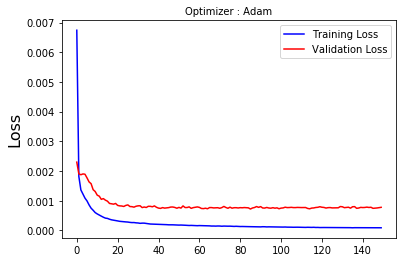

In [27]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [0]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [0]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

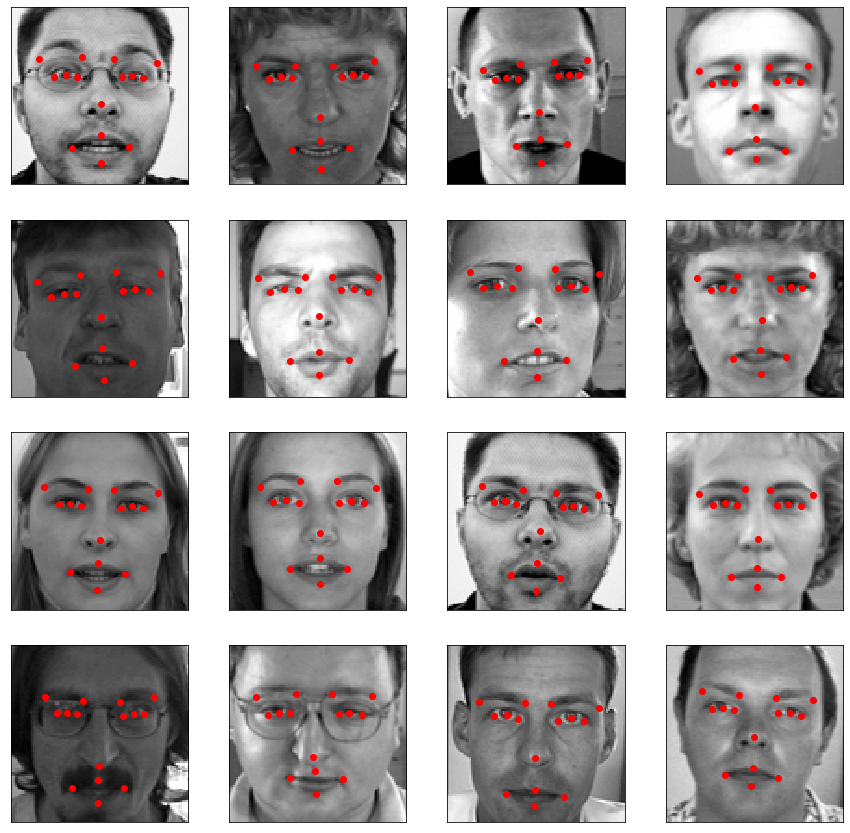

In [30]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [0]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [32]:
model_with_augment.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 128)        

In [33]:
# Your code

### refer: https://zhuanlan.zhihu.com/p/22918818
from keras.preprocessing.image import ImageDataGenerator

print('Using real-time data augmentation.')
train_datagen = ImageDataGenerator(              
        featurewise_center=True,  
        samplewise_center=True,  
        featurewise_std_normalization=True,  
        samplewise_std_normalization=True,  
        zca_whitening=False,  
        rotation_range=0, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        horizontal_flip=True, 
        vertical_flip=False)

train_generator = train_datagen.flow(imgs_train.reshape(-1, 96, 96, 1), points_train, batch_size=32)

hist_model = model_with_augment.fit_generator(train_generator,
                                steps_per_epoch=len(imgs_train.reshape(-1, 96, 96, 1)),
                                epochs=10,
                                callbacks=[checkpoint, hist],
                                shuffle=True,
                                verbose=1,
                                validation_data=(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1), points_test)
                                ) 
# save the model weights
model.save_weights('weights_with_augment.h5')
# save the model
model.save('model_with_augment.h5')

Using real-time data augmentation.
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


2140/2140 [==============================] - 626s 292ms/step - loss: 9.1659e-04 - val_loss: 8.0357e-04

Epoch 00001: val_loss did not improve from 0.00072
Epoch 2/10
2140/2140 [==============================] - 625s 292ms/step - loss: 5.3950e-04 - val_loss: 0.0011

Epoch 00002: val_loss did not improve from 0.00072
Epoch 3/10
2140/2140 [==============================] - 621s 290ms/step - loss: 4.3196e-04 - val_loss: 0.0018

Epoch 00003: val_loss did not improve from 0.00072
Epoch 4/10
2140/2140 [==============================] - 622s 291ms/step - loss: 3.7057e-04 - val_loss: 0.0022

Epoch 00004: val_loss did not improve from 0.00072
Epoch 5/10
2140/2140 [==============================] - 623s 291ms/step - loss: 3.2522e-04 - val_loss: 0.0015

Epoch 00005: val_loss did not improve from 0.00072
Epoch 6/10
2140/2140 [==============================] - 622s 291ms/step - loss: 2.9962e-04 - val_loss: 0.0012

Epoch 00006: val_loss did not improve from 0.00072
Epoch 7/10
2140/2140 [=============

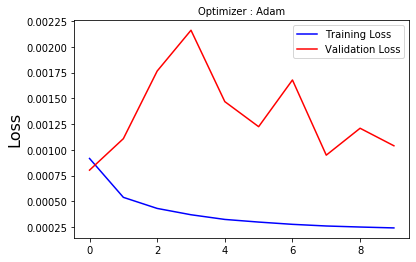

In [34]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

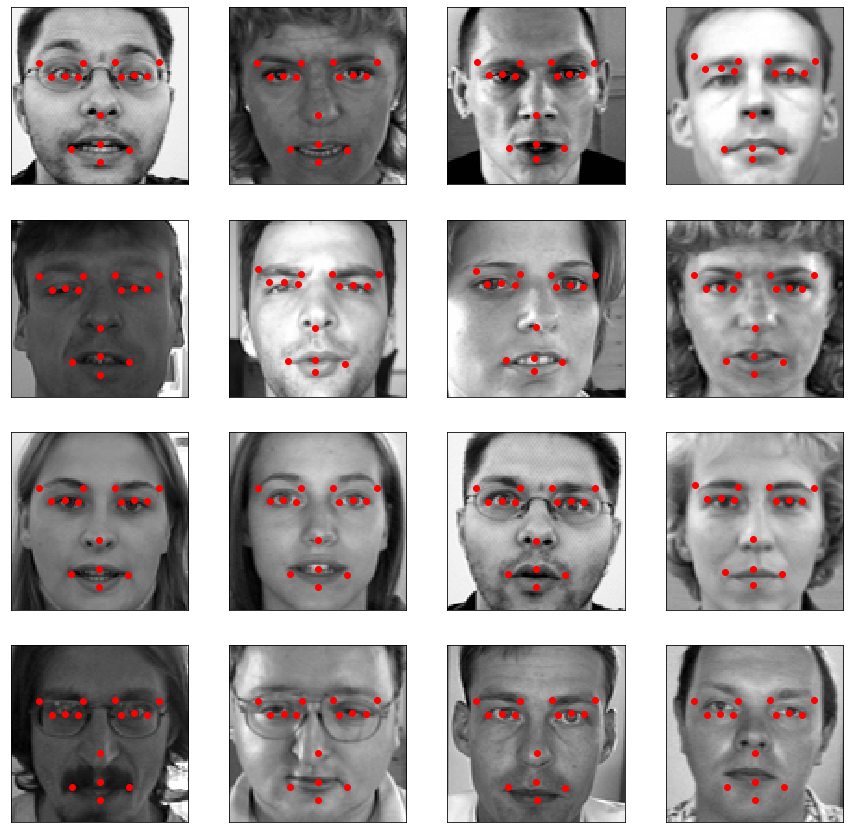

In [35]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model_with_augment.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))